In [1]:
# 사용 라이브러리 임포트

import tensorflow as tf
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
pd.options.display.max_colwidth = 500

In [142]:
# 사전에 다운로드 받은 경로를 통해 데이터 불러오기
filepath = os.getenv('HOME')+'/aiffel/dktc/data/train.csv'
data = pd.read_csv(filepath)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 3950


In [143]:
data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게.\n 정말 잘못했습니다.\n 너가 선택해. 너가 죽을래 네 가족을 죽여줄까.\n 죄송합니다. 정말 잘못했습니다.\n 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야.\n 선택 못하겠습니다. 한번만 도와주세요.\n 그냥 다 죽여버려야겠군. 이의 없지?\n 제발 도와주세요.
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 한번만 더 얘기한다.\n장난전화 걸지 마시죠. \n9시 40분 마트에 폭발물이 터지면 다 죽는거야. \n장난전화는 업무방해죄에 해당됩니다.\n판단은 너에게 달려있다. 길동경찰서에도 폭발물 터지면 꽤나 재미있겠지.\n선생님 진정하세요.\n난 이야기했어. 경고했다는 말이야.
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미없어.\n지영아 너가 키 160이지? 그럼 재는 160도 안돼는거네?\n너 군대도 안가고 좋겠다.\n니들이 나 작은데 보태준거 있냐?\n난쟁이들도 장가가고하던데. 너도 희망을 가져봐 \n더이상 하지마라. \n그 키크는 수술도 있대잖아? 니네 엄마는 그거 안해주디?\n나람 해줬어. 저 키로 어찌살아.\n제발 그만 괴롭히라고!
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?\n얘 돈 좀 있나봐\n아니에요.돈 없어요\n뒤져서 나오면 넌 죽는다\n오늘 피시방 콜?\n콜. 마지막 기회다. 있는거 다 내놔\n정말 없어요
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 발라보실래요?\n아 진짜요? 안 그래도 선크림 필요해서 알아보던 중인데 한 번 발라 볼게요!\n여기 한 번 발라보세요. 진짜 성분도 좋고 다 좋아요.\n음. 성분이 좋다고 하셔서 좋은거 같기는 한데 제 피부에 맞지 않나봐요. 피부가 따끔거리네요.\n이번에 진짜 열심히 연구해서 만든건데 피부가 많이 예민하신가봐요.\n네 많이 예민해요. 그럼 많이 파시고 안녕히 계세요.\n아니 저기요 돈 안내요?\n네? 발라보는것도 돈 내야 하나요?\n그럼 이거 누구한테 팔아요? 당신이 바른거를?\n아니 먼저 발라 보시라고 하셨잖아요. 먼저 권유해놓고 사라고 강매하는거 갈취인거 몰라요?\n내가 안 사도 된다고 말 한 적 있어? 그것도 모르고 바른걸 누구 탓 하나? 빨리 사 당신이 바른거 당신이 사야지\n진짜 어이가 없어서 다른 사람들한텐 이렇게 갈취하지마세요. 화딱지나네


전처리

In [144]:
# 중복 제거 및 Null 값 제거
data.drop_duplicates(inplace=True)
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 3950


In [145]:
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower()

    sentence = re.sub(r"\n", "", sentence)   # 문장 끝에 온점 
    sentence = re.sub(r"([?.!,])", " ", sentence)   # 문자를 한번만 사용 .. --> .
#     sentence = re.sub(r"([?.!,])\1+", "\1", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)  # white space 데이터를 empty value로 변경

    # (문자, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r'[^\w\W]', "", sentence)
    return sentence.strip()

In [146]:
# Q 데이터 전처리
clean_conv = data['conversation'].apply(lambda x: preprocess_sentence(x)).tolist()

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_conv[:5])

Text 전처리 후 결과:  ['지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 진짜 죽여버리고 싶게 정말 잘못했습니다 너가 선택해 너가 죽을래 네 가족을 죽여줄까 죄송합니다 정말 잘못했습니다 너에게는 선택권이 없어 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야 선택 못하겠습니다 한번만 도와주세요 그냥 다 죽여버려야겠군 이의 없지 제발 도와주세요', '길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 얘기한다 장난전화 걸지 마시죠 9시 40분 마트에 폭발물이 터지면 다 죽는거야 장난전화는 업무방해죄에 해당됩니다 판단은 너에게 달려있다 길동경찰서에도 폭발물 터지면 꽤나 재미있겠지 선생님 진정하세요 난 이야기했어 경고했다는 말이야', '너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지영아 너가 키 160이지 그럼 재는 160도 안돼는거네 너 군대도 안가고 좋겠다 니들이 나 작은데 보태준거 있냐 난쟁이들도 장가가고하던데 너도 희망을 가져봐 더이상 하지마라 그 키크는 수술도 있대잖아 니네 엄마는 그거 안해주디 나람 해줬어 저 키로 어찌살아 제발 그만 괴롭히라고', '어이 거기예 너 말이야 너 이리 오라고무슨 일 너 옷 좋아보인다 얘 돈 좀 있나봐아니에요 돈 없어요뒤져서 나오면 넌 죽는다오늘 피시방 콜 콜 마지막 기회다 있는거 다 내놔정말 없어요', '저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발라보실래요 아 진짜요 안 그래도 선크림 필요해서 알아보던 중인데 한 번 발라 볼게요 여기 한 번 발라보세요 진짜 성분도 좋고 다 좋아요 음 성분이 좋다고 하셔서 좋은거 같기는 한데 제 피부에 맞지 않나봐요 피부가 따끔거리네요 이번에 진짜 열심히 연구해서 만든건데 피부가 많이 예민하신가봐요 네 많이 예민해요 그럼 많이 파시고 안녕히 계세요 아니 저기요 돈 안내요 네 발라보는것도 돈 내야 하나요 그럼 이거 누

In [147]:
data['conversation'] = clean_conv

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)
df_cleaned = data.copy(deep=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 3950


토큰화

In [99]:
import tensorflow_datasets as tfds


# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    clean_conv, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8096]
END_TOKEN의 번호 : [8097]


In [100]:
# 토큰화 된 100개의 서브워드들을 출력
print(tokenizer.subwords[:100])

['내가_', '너_', '야_', '네_', '나_', '이_', '좀_', '아_', '도_', '다_', '왜_', '고_', '지_', '게_', '진짜_', '는_', '가_', '아니_', '지금_', '요_', '면_', '을_', '니_', '거_', '서_', '에_', '돈_', '그럼_', '어_', '은_', '죄송합니다_', '그냥_', '안_', '내_', '제가_', '한_', '그래_', '저_', '무슨_', '뭐_', '를_', '이거_', '만_', '해_', '그_', '제발_', '더_', '그렇게_', '로_', '우리_', '니가_', '냐_', '잘_', '어떻게_', '수_', '너무_', '할_', '이', '아니야_', '오늘_', '지', '하고_', '못_', '빨리_', '정말_', '데_', '것_', '넌_', '그게_', '거야_', '너가_', '나도_', '어', '이렇게_', '요', '니까_', '그건_', '일_', '난_', '말_', '안', '줄_', '응_', '다', '가', '잖아_', '자', '고', '없어_', '라고_', '네', '는데_', '여기_', '아', '있어_', '까지_', '으로_', '뭘_', '나', '근데_']


In [101]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8098


In [102]:
sample_string = data['conversation'][21]

# 인코딩한 결과를 tokenized_string에 저장
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 : {}'.format(tokenized_string))

# 이를 다시 디코딩
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장 : {}'.format(original_string))

정수 인코딩 후의 문장 : [2, 427, 380, 4089, 115, 27, 5107, 1577, 86, 4304, 22, 11, 19, 5512, 3, 10, 2775, 3449, 191, 695, 106, 1206, 1, 11, 2718, 2252, 10, 2775, 6616, 2675, 51, 3763, 717, 27, 184, 2030, 123, 1924, 1707, 923, 707, 21, 2252, 6943, 4389, 3, 19, 6155, 89, 630, 2775, 3668, 397, 482, 802]
기존 문장 : 너 저번에 친구 지갑에서 돈 훔쳤잖아 그말을 왜 지금 꺼내 야 다 불어버리기전에 얼마 나한테 줘봐 내가 왜 줘야되는데 다 불어버릴거라니까 니가 가져간 돈 주인이랑 모든 사람들에게 얼마면 되는데 10만원만 줘라 야 지금 10만원 없어 확 불어버릴까보다 내일까지 줄게


conversation의 최소 길이 : 1
conversation의 최대 길이 : 219
conversation의 평균 길이 : 54.13569620253165


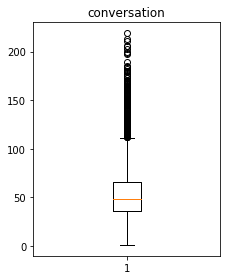

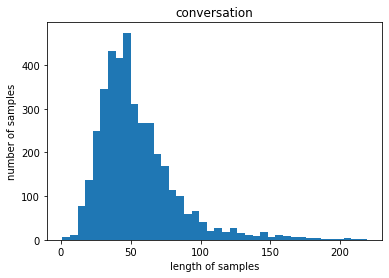

In [103]:
# 길이 분포 출력


text_len = [len(s.split()) for s in data['conversation']]

print('conversation의 최소 길이 : {}'.format(np.min(text_len)))
print('conversation의 최대 길이 : {}'.format(np.max(text_len)))
print('conversation의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('conversation')
plt.tight_layout()
plt.show()

plt.title('conversation')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [105]:
original_string

'너 저번에 친구 지갑에서 돈 훔쳤잖아 그말을 왜 지금 꺼내 야 다 불어버리기전에 얼마 나한테 줘봐 내가 왜 줘야되는데 다 불어버릴거라니까 니가 가져간 돈 주인이랑 모든 사람들에게 얼마면 되는데 10만원만 줘라 야 지금 10만원 없어 확 불어버릴까보다 내일까지 줄게'

In [106]:
with open('conversation.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(data['conversation']))

In [108]:
from tokenizers import BertWordPieceTokenizer



tokenizer = BertWordPieceTokenizer(lowercase=False, strip_accents=False)

data_file = 'conversation.txt'
vocab_size = 30000
limit_alphabet = 9000
min_frequency = 5

tokenizer.train(files=data_file,
                vocab_size=vocab_size,
                limit_alphabet=limit_alphabet,
                min_frequency=min_frequency)


In [109]:
# vocab 저장
tokenizer.save_model('./')

['./vocab.txt']

In [110]:
# vocab 로드
df = pd.read_fwf('vocab.txt', header=None)
df.head()

,0
0,[PAD]
1,[UNK]
2,[CLS]
3,[SEP]
4,[MASK]


In [114]:
encoded = tokenizer.encode('지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 진짜 죽여버리고 싶게 정말 잘못했습니다 너가 선택해 너가 죽을래 네 가족을 죽여줄까 죄송합니다 정말 잘못했습니다 너에게는 선택권이 없어 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야 선택 못하겠습니다 한번만 도와주세요 그냥 다 죽여버려야겠군 이의 없지 제발 도와주세요')
print('토큰화 결과 :',encoded.tokens)
print('정수 인코딩 :',encoded.ids)
print('디코딩 :',tokenizer.decode(encoded.ids))

토큰화 결과 : ['지금', '너', '스스로', '##를', '죽여', '##달라고', '애', '##원', '##하는', '것', '##인가', '아닙니다', '죄송합니다', '죽을', '거면', '혼자', '죽지', '우리', '##까지', '사건에', '휘', '##말', '##리게', '해', '진짜', '죽여버리고', '싶', '##게', '정말', '잘못했습니다', '너가', '선택해', '너가', '죽을래', '네', '가족을', '죽여줄까', '죄송합니다', '정말', '잘못했습니다', '너에게', '##는', '선택권', '##이', '없어', '선택', '못한다', '##면', '너와', '네', '가족까지', '모', '##조리', '죽여버릴거야', '선택', '못하겠', '##습니다', '한번만', '도와주세요', '그냥', '다', '죽여', '##버려야', '##겠군', '이', '##의', '없지', '제발', '도와주세요']
정수 인코딩 : [2795, 230, 6465, 1535, 2913, 3473, 902, 1643, 2827, 50, 3393, 2930, 2799, 3252, 9608, 3170, 9085, 2801, 2809, 12060, 1468, 1727, 4140, 1413, 2792, 5605, 834, 1559, 2842, 5036, 2862, 10484, 2862, 5257, 238, 7173, 9335, 2799, 2842, 5036, 6956, 1549, 9503, 1493, 2818, 4341, 6985, 1586, 7728, 238, 9356, 572, 10092, 3564, 4341, 8140, 2784, 3124, 5032, 2805, 292, 2913, 6164, 7499, 1011, 1723, 3468, 2816, 5032]
디코딩 : 지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 진짜 죽여버리고 싶게 정말 잘못했습니다 너가 선택

# koBERT

참고 링크
[https://velog.io/@jiyoung/Text-ClassificationKoBERT%EB%A1%9C-%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0-%EC%BD%94%EB%93%9C]


In [123]:
# !pip install gluonnlp
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-0z5gmf28
  Running command git clone --filter=blob:none -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-0z5gmf28
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 129 kB 5.4 MB/s            
     |████████████████████████████████| 54.7 MB 21 kB/s              
     |████████████████████████████████| 4.5 MB 55.1 MB/s            
     |████████████████████████████████| 2.5 MB 53.6 MB/s            
     |█████████████████

In [124]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [129]:
data.head(10)

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 진짜 죽여버리고 싶게 정말 잘못했습니다 너가 선택해 너가 죽을래 네 가족을 죽여줄까 죄송합니다 정말 잘못했습니다 너에게는 선택권이 없어 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야 선택 못하겠습니다 한번만 도와주세요 그냥 다 죽여버려야겠군 이의 없지 제발 도와주세요
1,1,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 얘기한다 장난전화 걸지 마시죠 9시 40분 마트에 폭발물이 터지면 다 죽는거야 장난전화는 업무방해죄에 해당됩니다 판단은 너에게 달려있다 길동경찰서에도 폭발물 터지면 꽤나 재미있겠지 선생님 진정하세요 난 이야기했어 경고했다는 말이야
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지영아 너가 키 160이지 그럼 재는 160도 안돼는거네 너 군대도 안가고 좋겠다 니들이 나 작은데 보태준거 있냐 난쟁이들도 장가가고하던데 너도 희망을 가져봐 더이상 하지마라 그 키크는 수술도 있대잖아 니네 엄마는 그거 안해주디 나람 해줬어 저 키로 어찌살아 제발 그만 괴롭히라고
3,3,갈취 대화,어이 거기예 너 말이야 너 이리 오라고무슨 일 너 옷 좋아보인다 얘 돈 좀 있나봐아니에요 돈 없어요뒤져서 나오면 넌 죽는다오늘 피시방 콜 콜 마지막 기회다 있는거 다 내놔정말 없어요
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발라보실래요 아 진짜요 안 그래도 선크림 필요해서 알아보던 중인데 한 번 발라 볼게요 여기 한 번 발라보세요 진짜 성분도 좋고 다 좋아요 음 성분이 좋다고 하셔서 좋은거 같기는 한데 제 피부에 맞지 않나봐요 피부가 따끔거리네요 이번에 진짜 열심히 연구해서 만든건데 피부가 많이 예민하신가봐요 네 많이 예민해요 그럼 많이 파시고 안녕히 계세요 아니 저기요 돈 안내요 네 발라보는것도 돈 내야 하나요 그럼 이거 누구한테 팔아요 당신이 바른거를 아니 먼저 발라 보시라고 하셨잖아요 먼저 권유해놓고 사라고 강매하는거 갈취인거 몰라요 내가 안 사도 된다고 말 한 적 있어 그것도 모르고 바른걸 누구 탓 하나 빨리 사 당신이 바른거 당신이 사야지진짜 어이가 없어서 다른 사람들한텐 이렇게 갈취하지마세요 화딱지나네
5,5,직장 내 괴롭힘 대화,나 이틀뒤에 가나다 음식점 예약좀 해줘 저녁7시로 가나다 음식점이요 응 남자친구 부모님한테 인사드리려는데 거기가 예약이 좀 힘들어 그러니까 수진씨가 좀 해줘 저 팀장님 저도 월 말 프로젝트로 정신없어서 죄송하지만 사회생활 안 해본 티를 너무 내는거 아니야 프로젝트만 백날 잘하면 뭐해 윗 상사한테 잘 보이기도 해야지 하지만 팀 프로젝트라서 이번엔 말 참 이상하게 하네 이번엔 내가 뭐 매일같이 이런 심부름이나 시킨다는거야 뭐야 아닙니다 제가 말 실수 했습니다 말씀하신 예약 꼭 해두겠습니다 이러면 하고도 욕먹는거야 한번에 네네 알겠습니다 하면 좀 좋아 죄송합니다 알겠습니다
6,6,기타 괴롭힘 대화,35번 손님 아이스커피 두잔나왔습니다아이스커피 네 맛있게드세요저기요 아가씨 나는 아아스 시킨적이 없는데 아 분명 오늘 날이 더우시다고 아이스로 시키셨는데요내가 그랫어 네분명히 아그런 기억이 없는데 아가씨가잘못안거 아니야 아니요 오늘 손님이 첫 주문이라 확실히 기억하고 있습니다아가씨 왜이렇게 유도리가 없이 굴어 그냥 아 제가 잘못 주문 받았습니다 하면 되지 네 어휴 유도리 없어 그냥 마실게
7,7,기타 괴롭힘 대화,경비아저씨 내차에 경고장 붙였어요 내가 여기 몇년째 사는데 아직도 내차인줄 모르고 이딴식으로 경고장을 붙여 입주민께서 정해진 주차자리가 아닌 통로에 계속 주차하셔서 입주민들 항의가 계속 들어옵니다 내가 항상 대는 거기 자리가 없으니까 그렇지 내차 이거 어떻게 할거요 얼마짜린줄 알아 수차례 인터폰도 드렸고 경고장을 올렸으나 몇일째 그대로 인지라 아파트규약에 맞춰 어쩔수 없었습니다그렇다고 본드로 붙이면 어떻게 당장 이거 깨끗히 원상복구시키고 세차해와그럴 수는 없습니다 내가 낸 관리비로 월급받는 주제에 뭐라는거야 안붙혔으면 되잖아 나 지금 거기 가요 말씀이 과하신거 아닙니까 딱 기다려요 이름뭐죠 나 지금 가면 당신 이제 끝이야
8,8,기타 괴롭힘 대화,이거 할인 된다면서요 확인해보겠습니다 아까 저 시람은 할인 해주던데 네 저 손님은 고객님이십니다 고객을 차별하는 거에요 저희는 등급제로 운영돼서 그런겁니다 점장 불러오세요 손님 이건 점장님도 해결해주시지 못합니다 그니까 점장 불러와 진정을 좀 해보세요
9,9,갈취 대화,자네 세금계산서 보내준 거 메일이랑 수치가 다르던데 그게 얼마나 해먹었어 괜찮아 다른 업체들도 다 그래 회사에는 비밀로 해주십시오 그래그래 근데 성의는 표시해야지 어느정도 생각하시죠 10장 네가 많이도 해먹었는데 그정도는 되겠지 그건 너무 많습니다 그럼 김사장한테 직접 말하는 수밖에 없지 그리고 이 건은 국세청에도 걸리는거 알지 좀 더 기한을 주십시오


In [131]:
data['class'].drop_duplicates()

0          협박 대화
2      기타 괴롭힘 대화
3          갈취 대화
5    직장 내 괴롭힘 대화
Name: class, dtype: object

In [160]:
##GPU 사용 시
device = torch.device("cuda:0")

In [148]:
#bert 모델, vocab 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /aiffel/aiffel/dktc/src/.cache/kobert_v1.zip
using cached model. /aiffel/aiffel/dktc/src/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [151]:
data.loc[(data['class'] == "협박 대화"), 'label'] = 0  #협박 대화 => 0
data.loc[(data['class'] == "갈취 대화"), 'label'] = 1  #갈취 대화 => 1
data.loc[(data['class'] == "갈취 대화"), 'label'] = 2  #갈취 대화 => 2
data.loc[(data['class'] == "직장 내 괴롭힘 대화"), 'label'] = 3  #갈취 대화 => 3
data.loc[(data['class'] == "기타 괴롭힘 대화"), 'label'] = 4  #갈취 대화 => 4
data.loc[(data['class'] == "일반 대화"), 'label'] = 5  #기타 괴롭힘 대화 => 5

data_list = []
for content, label in zip(data['conversation'], data['label'])  :
    temp = []
    temp.append(content)
    temp.append(str(int(label)))

    data_list.append(temp)

In [152]:
print(data_list[0])
print(data_list[-1])

['지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 진짜 죽여버리고 싶게 정말 잘못했습니다 너가 선택해 너가 죽을래 네 가족을 죽여줄까 죄송합니다 정말 잘못했습니다 너에게는 선택권이 없어 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야 선택 못하겠습니다 한번만 도와주세요 그냥 다 죽여버려야겠군 이의 없지 제발 도와주세요', '0']
['희정씨네 주말에 시간이 넘쳐나나봐갑자기 왜그러세요 손이 빤짝빤짝 네일했니 네 여름이라 기분전환으로 어휴 그손으로 결제 받으러 가면 윗분들 눈 아프시겠다 정신사나워그냥 파스텔톤으로만 칠한건데 희정씨가 윗사람이야 얼른 가서 지우고와 네', '3']


In [153]:
#train & test 데이터로 나누기
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.25, random_state=0)

In [154]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [155]:
## Setting parameters
max_len = 300
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [156]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
#BERTDataset 클래스 이용, TensorDataset으로 만들어주기
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /aiffel/aiffel/dktc/src/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [157]:
#배치 및 데이터로더 설정
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=4)

In [158]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=46, ##주의: 클래스 수 바꾸어 주세요!##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [161]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device) #gpu

In [163]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [164]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [165]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [166]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} validation acc {}".format(e+1, test_acc / (batch_id+1)))

/tmp/ipykernel_55/2556362077.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/47 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

RuntimeError: CUDA out of memory. Tried to allocate 264.00 MiB (GPU 0; 14.58 GiB total capacity; 12.97 GiB already allocated; 231.56 MiB free; 13.15 GiB reserved in total by PyTorch)